In [2]:
import random
from utils.snowflake_funcs import snowflake_connector  
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
from scipy import stats
from sklearn.preprocessing import OneHotEncoder
import xgboost as xgb

## Load data

In [28]:
# load data from the database by SQL

## Data preprocessing

In [ ]:
# delete rows with strange install date
data['INSTALL_DATE'] = pd.to_datetime(data['INSTALL_DATE'])
cutoff_date = pd.to_datetime('2024-04-07')
df_correct_date = data.loc[data['INSTALL_DATE'] <= cutoff_date, ]

# label new users
cutoff_date = pd.to_datetime('2024-04-01')
df_correct_date.loc[df_correct_date['INSTALL_DATE'] >= cutoff_date, 'NEW_USERS'] = 1
df_correct_date.loc[df_correct_date['INSTALL_DATE'] < cutoff_date, 'NEW_USERS'] = 0

df_correct_date

In [ ]:
# encode categorical variables
# fill nan in pre experimnet data with 0

df_cupac_encoded = pd.get_dummies(df_correct_date, columns=['PLATFORM', 'COUNTRY_CODE', 'DEVICE_TYPE'])
df_cupac_encoded['PRE_NUM_GAME_START'] = df_cupac_encoded['PRE_NUM_GAME_START'].fillna(0)

df_cupac_encoded

In [9]:
# check the number of missing value
df_cupac_encoded.isnull().sum().sum()

0

In [10]:
df_cleaned = df_cupac_encoded.copy()

## Get estimated covariates by machine learning model

In [11]:
# Select variates that can provide information to estimate covariate
variates = list(df_cleaned.columns)
variates.remove('INSTALL_PK')
variates.remove('NUM_GAME_START')
variates.remove('INSTALL_DATE')
print(variates)

['PRE_NUM_GAME_START', 'COHORT_DAY', 'NEW_USERS', 'PLATFORM_android', 'PLATFORM_ios', 'COUNTRY_CODE_AD', 'COUNTRY_CODE_AE', 'COUNTRY_CODE_AF', 'COUNTRY_CODE_AG', 'COUNTRY_CODE_AI', 'COUNTRY_CODE_AL', 'COUNTRY_CODE_AM', 'COUNTRY_CODE_AO', 'COUNTRY_CODE_AQ', 'COUNTRY_CODE_AR', 'COUNTRY_CODE_AS', 'COUNTRY_CODE_AT', 'COUNTRY_CODE_AU', 'COUNTRY_CODE_AW', 'COUNTRY_CODE_AX', 'COUNTRY_CODE_AZ', 'COUNTRY_CODE_BA', 'COUNTRY_CODE_BB', 'COUNTRY_CODE_BD', 'COUNTRY_CODE_BE', 'COUNTRY_CODE_BF', 'COUNTRY_CODE_BG', 'COUNTRY_CODE_BH', 'COUNTRY_CODE_BI', 'COUNTRY_CODE_BJ', 'COUNTRY_CODE_BL', 'COUNTRY_CODE_BM', 'COUNTRY_CODE_BN', 'COUNTRY_CODE_BO', 'COUNTRY_CODE_BQ', 'COUNTRY_CODE_BR', 'COUNTRY_CODE_BS', 'COUNTRY_CODE_BT', 'COUNTRY_CODE_BW', 'COUNTRY_CODE_BY', 'COUNTRY_CODE_BZ', 'COUNTRY_CODE_CA', 'COUNTRY_CODE_CD', 'COUNTRY_CODE_CF', 'COUNTRY_CODE_CG', 'COUNTRY_CODE_CH', 'COUNTRY_CODE_CI', 'COUNTRY_CODE_CK', 'COUNTRY_CODE_CL', 'COUNTRY_CODE_CM', 'COUNTRY_CODE_CN', 'COUNTRY_CODE_CO', 'COUNTRY_CODE_CR', 'C

In [ ]:
# Build a XGBoost models to get covariates
# X: previous number of game start, cohort day, platform, country, device type, new user
# Y: target metric (number of game start)
# the predictions are the estimated covariates

# We set the train and test sets as the entire dataset. Explanations are in the paper
X_train = df_cleaned[variates]
X_test = df_cleaned[variates]

y_train = df_cleaned['NUM_GAME_START']
model = xgb.XGBRegressor()
model.fit(X_train,y_train)

# add covariates to the dataset
df_ml_result = df_cleaned.copy()
df_ml_result["Estimated_covariate"] = model.predict(X_test)
df_ml_result.head()

## CUPED adjustment

In [13]:
# identical function with the one in Model 3, 'aa_test_cuped.ipynb', except we use the estimated covariate as covariate not previous number of game start
def get_cupac_adjusted(data, covariate):
    theta = data[covariate].cov(data['NUM_GAME_START']) / data[covariate].var()
    data['ADJUSTED_NUM_GAME_START'] = data['NUM_GAME_START'] - theta * (data[covariate] - data[covariate].mean())
    
    return data

In [ ]:
# gat CUPED adjusted target metric
final_data = get_cupac_adjusted(df_ml_result, 'Estimated_covariate')
final_data.head()

## A/A test

In [15]:
def calculate_avg_new_game_start(data):
    total_game_start = data['ADJUSTED_NUM_GAME_START'].sum()
    total_users = data['INSTALL_PK'].nunique()

    return total_game_start/total_users

In [16]:
# main
game_start_difference_cupac_2 = []

for i in range(0, 1000):
    print(i)
    
     # split data to treatment and control groups randomly
    treatment, control = train_test_split(final_data, test_size=0.5, shuffle=True)

    # calculate the mean of target metric
    t_game_start = calculate_avg_new_game_start(treatment)
    c_game_start = calculate_avg_new_game_start(control)

    # store the difference
    game_start_difference_cupac_2.append(t_game_start - c_game_start)
    
game_start_difference_cupac_2

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
27

[-0.02496631020608575,
 0.04918469336587705,
 -0.0016117951597252045,
 0.032986419193633765,
 0.0056687063731040155,
 0.03938545469378596,
 -0.012993666936530701,
 0.014621623706865705,
 0.033405331487823986,
 0.024678203654190156,
 -0.05918338064056172,
 -0.011770876015098963,
 0.017534254682338712,
 -0.035564573240005615,
 -0.03232424610512297,
 -0.016659166563428585,
 -0.023665519287117576,
 -0.03617789620628997,
 -0.008966337303583316,
 0.04147902066627651,
 -0.010963425002550764,
 -0.01972326778211908,
 -0.026248734924013917,
 -0.056609211299221585,
 -0.001850219144643006,
 0.007966863793182455,
 -0.0006330770735303304,
 -0.020432769686003383,
 0.03240604651287882,
 -0.05691818704745444,
 0.014847699611472365,
 -0.030595776420543785,
 0.0036030605948447203,
 -0.020388113544985487,
 -0.008899305201474306,
 -0.028502629162556303,
 0.028444795357120967,
 0.007667376633801126,
 0.00047351806204432023,
 -0.0003553133769962358,
 -0.020246220601752185,
 0.0005116910229254756,
 0.10501916

## Result visualisation

In [17]:
df_game_start_difference_cupac_2 = pd.DataFrame(game_start_difference_cupac_2,dtype=float)
df_game_start_difference_cupac_2

,0
0,-0.024966
1,0.049185
2,-0.001612
3,0.032986
4,0.005669
...,...
995,0.024648
996,0.025080
997,0.044770
998,-0.016425


<Axes: ylabel='Density'>

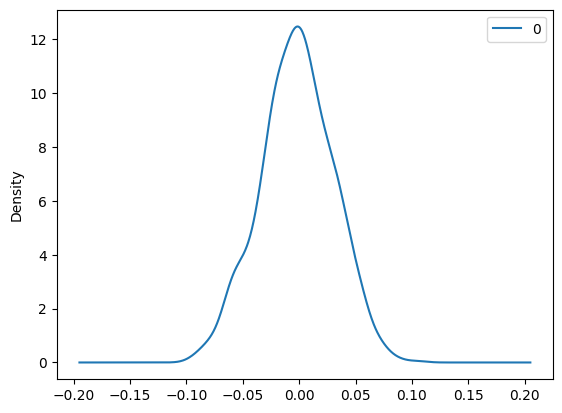

In [18]:
df_game_start_difference_cupac_2.plot.kde()

/var/folders/vx/w5z5d3dd317gflztcs29ll8h0000gn/T/ipykernel_24298/483362563.py:2: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(df_game_start_difference_cupac_pre_data_0)


Text(0, 0.5, 'Density')

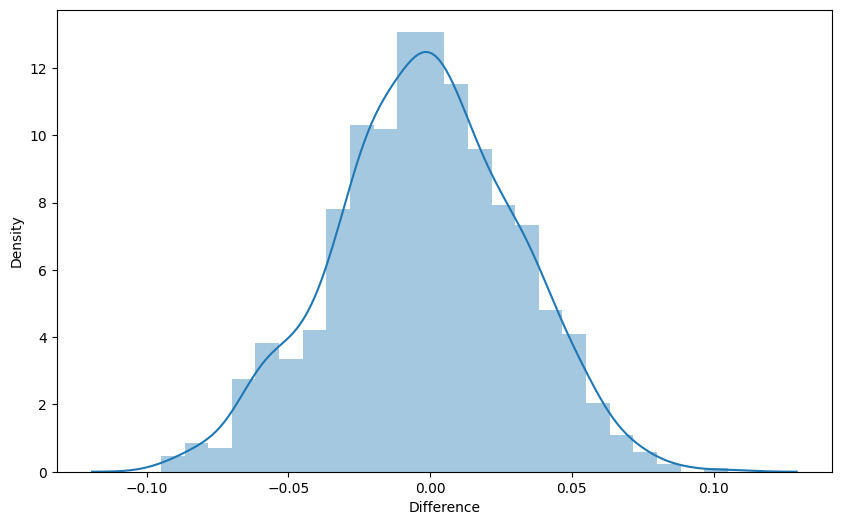

In [5]:
plt.figure(figsize=(10, 6))
sns.distplot(df_game_start_difference_cupac_2)
plt.xlabel('Difference')
plt.ylabel('Density')

In [19]:
df_game_start_difference_cupac_2.to_pickle('result/model6.pkl')